### Email:

Az volna az elso kerdes, hogy a jelenlegi adatokbol hogy latjuk vissza az 500 altalunk tervezett oligot, vagyis milyen azok reprezentacioja.

Technikailag ket dolgot csinaltunk, ezert van egy rovidebb es egy hosszabb amplikon. A rovidebb, közvetlenül a hatarszekvenciakkal kezdodik es vegzodik.

- oV869_P7NP_fw TCTTGTGGAAAGGACGAAACACCG
- oV870_P7NP_rev GTTTAAGAGCTATGCTGGAAACAG

A hosszabbnak ezek kb pont a kozepen vannak. Nagyjából fele-fele aranyban kevertuk ossze a ket PCR termeket, a kerdes az volna, hogy melyik hasznalhatobb minoseg es reprezentacio szempontjából, azzal mennénk majd tovabb.

In [1]:
#imports
from utils import *
from speedup import *

import pod5

--- Warning! This version of speedup.py can cause errors. ---


In [ ]:
thymine_path = "/v/volumes/nanopore/timin_uracil/oligos/timin20250417/20250417_1447_MC-114328_AXB238_56275db9/"

---
# Pod5 dataset

In [ ]:
thymine_pod5_path  = thymine_path + "pod5/"
thymine_pod5_files = glob(thymine_pod5_path+"*")

In [ ]:
len(thymine_pod5_files)

In [ ]:
c = 0
for file in thymine_pod5_files:
    with pod5.Reader(file) as reader:
        for read in reader.reads():
            c+=1

In [ ]:
c

---
# Fastq dataset

In [ ]:
thymine_fastq_path = thymine_path + "fastq_pass/"
thymine_fastq_files = glob(thymine_fastq_path+"*")

In [ ]:
def read_fastq_gz(filepath):
    import gzip
    with gzip.open(filepath, 'rt') as f:  
        while True:
            header = f.readline().strip()
            if not header:
                break
            sequence = f.readline().strip()
            plus = f.readline().strip()
            quality = f.readline().strip()
            yield header, sequence, plus, quality

read_ids = []
fastq_sequences = []
len_sequences = []
max_idx=234 ##len(thymine_fastq_files) #== 234
iter_idx = 0
for file in tqdm(thymine_fastq_files[:max_idx], total=len(thymine_fastq_files[:max_idx]), desc="Loading data"):
    for header, sequence, plus, quality in read_fastq_gz(file):
        read_ids.append(header.split(' ')[0][1:])
        fastq_sequences.append(sequence)
        len_sequences.append(len(sequence))

In [ ]:
len_sequences_arr =  np.array(len_sequences)
len_sequences_arr = len_sequences_arr[(len_sequences_arr>=100) & (len_sequences_arr<=1000)]

In [ ]:
plt.figure(figsize=(9, 4.5))
plt.hist(len_sequences_arr, bins=900, color='b')
plt.title('Sequence lenght based on fastq files', fontsize=FS+3)
plt.xlabel('number of bases in a sequence', fontsize=FS)
plt.ylabel('frequency', fontsize=FS)
plt.xlim(100, 1000)
plt.grid()
plt.savefig('figures/seq_lengths.pdf')
plt.show()

In [ ]:
len(fastq_sequences)

---
# Dorado basecall -  mapped vs unmapped lengths

```python
%%bash
minimap2="/v/scratch/tools/minimap2/minimap2"

REF="references/reference_oligos.fasta" 
READS_DIR="/v/volumes/nanopore/timin_uracil/oligos/timin20250417/basecall/20250507/bam_to_fastq"
OUT_DIR="/v/projects/nanopore/balazs/data/new_dataset/thymine_250417/minimap2/dorado_alignments"

mkdir -p "$OUT_DIR"

for READ_FILE in "$READS_DIR"/*.fastq; do
    BASENAME=$(basename "$READ_FILE" .fastq)
    $minimap2 -x sr -a "$REF" "$READ_FILE" > "$OUT_DIR/${BASENAME}.sam"
done
```

In [2]:
dorado_alignments_file = "/v/projects/nanopore/balazs/data/new_dataset/thymine_250417/"+\
                         "minimap2/dorado_alignments/calls_2025-05-08_T08-20-58.sam"

In [8]:
sam_data_mapped = read_sam(dorado_alignments_file,
                           min_length=100,
                           max_length=1000,
                           verbose=True,
                           has_movetable=False,
                           possible_sam_flags={0,16}
                           )
len_seq_mapped = get_feature_from_sam_data(sam_data_mapped, 'len_sequence')


Loading files: 100%|██████████| 1/1 [00:56<00:00, 56.65s/file]

Number of reads stored: 854223
Number of reads dropped: 546801


In [12]:
sam_data_unmapped = read_sam(dorado_alignments_file,
                             min_length=100,
                             max_length=1000,
                             verbose=True,
                             has_movetable=False,
                             possible_sam_flags={4}
                             )
len_seq_unmapped = get_feature_from_sam_data(sam_data_unmapped, 'len_sequence')

Loading files: 100%|██████████| 1/1 [00:39<00:00, 39.30s/file]

Number of reads stored: 494396
Number of reads dropped: 906628


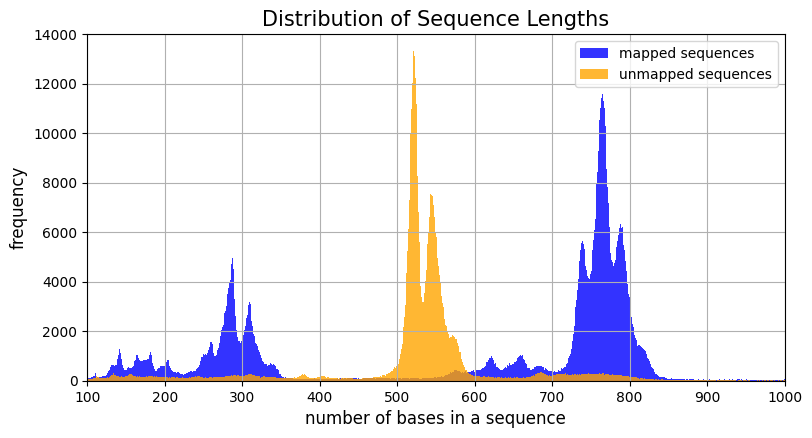

In [21]:
plt.figure(figsize=(9, 4.5))
plt.hist(len_seq_mapped, bins=900, color='b', label='mapped sequences', alpha=0.8)
plt.hist(len_seq_unmapped, bins=900, color='orange', label='unmapped sequences', alpha=0.8)
plt.title('Distribution of Sequence Lengths', fontsize=FS+3)
plt.xlabel('number of bases in a sequence', fontsize=FS)
plt.ylabel('frequency', fontsize=FS)
plt.xlim(100, 1000)
plt.grid()
plt.legend()
plt.savefig('figures/seq_lengths.pdf')
plt.show()